In [1]:
import sys
sys.path.append('/home/seabra/fingerprint-enhancement/')
sys.path.append('/home/seabra/fingerprint-enhancement/src')


from models.enhancer_module import *
from models.components.ResUNet import *
from data.enhancer_train_datamodule import EnhancerTrainDataModule

In [ ]:
batch_size  = 2
data_dir   = '/storage/seabra/segmentation_study/train_data/'
data_module = EnhancerTrainDataModule(data_dir=data_dir, lat_subdir='/synth_lats_docs_mixed/', orient_subdir='/dirmap_gt_txt/', ref_subdir='basen_refs_full/', skel_subdir='ref_dist/', mask_subdir='/lat_masks_synth_lats_docs_mixed/', data_list='/lists/basenames/lat_list_nfiq80.txt', batch_size=batch_size)

data_module.setup()
x, orient_map, mask = next(iter(data_module.train_dataloader()))


In [3]:
mask.shape

torch.Size([2, 1, 512, 512])

In [4]:
x.shape

torch.Size([2, 1, 512, 512])

## visualize orig, skel, mask and mnt_map labels

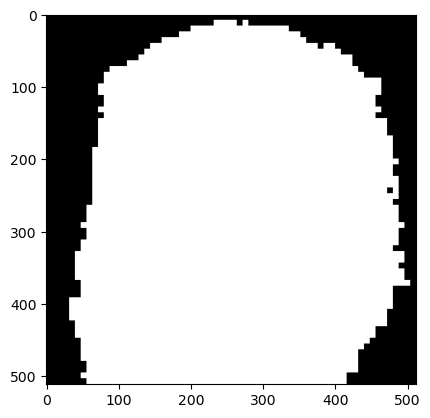

In [5]:
import matplotlib.pyplot as plt

plt.imshow(mask[0, 0, :, :], cmap = 'gray')

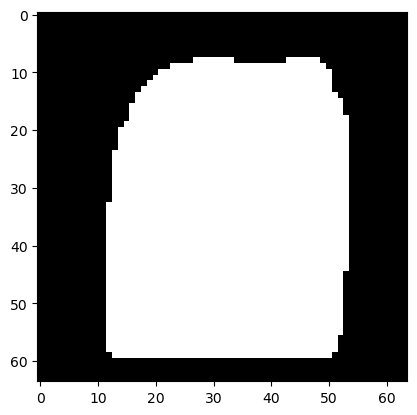

In [17]:
plt.imshow(-orient_map[0, 90, :, :], cmap = 'gray')

In [6]:
mask.shape

torch.Size([2, 1, 512, 512])

In [7]:
orig, bin, skel = labels[:,0,:,:],  labels[:,1,:,:],  labels[:,2,:,:]

NameError: name 'labels' is not defined

In [ ]:
labels.shape

torch.Size([2, 91, 64, 64])

Text(0.5, 1.0, 'Skel')

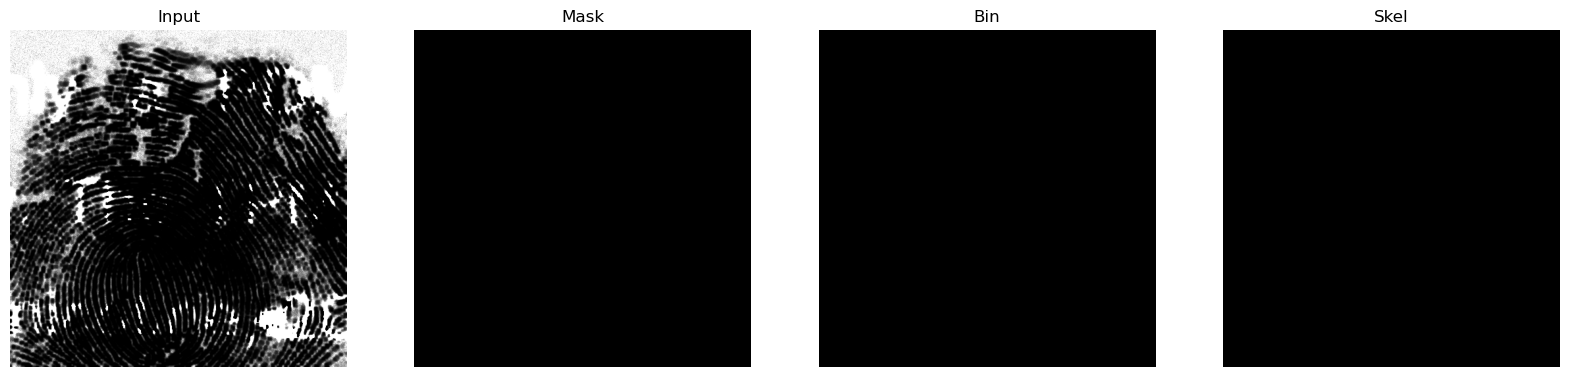

In [ ]:

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (20,15), nrows=1, ncols = 4)
ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Input')

ax[1].imshow(mask[0], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Mask')

ax[2].imshow(bin[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('Bin')

ax[3].imshow(skel[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('Skel')


In [ ]:
skel[0].min(), skel.max()

(tensor(0.), tensor(0.))

In [ ]:
from data.enhancer_predict_datamodule import *

model_path = '/home/seabra/fingerprint-enhancement/logs/train/runs/2025-09-19_00-56-23/checkpoints/epoch_048.ckpt'
model      = EnhancerLitModule.load_from_checkpoint(model_path)

device = 'cpu'

model = model.to(device)
x     = x.to(device)
with torch.no_grad():
    model.eval()
    # enh, mask, mnts, orifield = model.forward(x)
    enh = model.forward(x)

print(enh.shape)

fig, ax = plt.subplots(figsize = (20,15), nrows=1, ncols = 5)
ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Input')

ax[1].imshow(orig[0], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Orig')

ax[2].imshow(bin[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('Ground-truth Binarized')

ax[3].imshow(skel[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('Distance Map')

ax[4].imshow(enh[0][1], cmap = 'gray')
ax[4].axis('off')
ax[4].set_title('Pred')

FileNotFoundError: [Errno 2] No such file or directory: '/home/seabra/fingerprint-enhancement/logs/train/runs/2025-09-19_00-56-23/checkpoints/epoch_048.ckpt'

Simple loss:  tensor(0.0956)
Weighted loss:  tensor(0.0939)


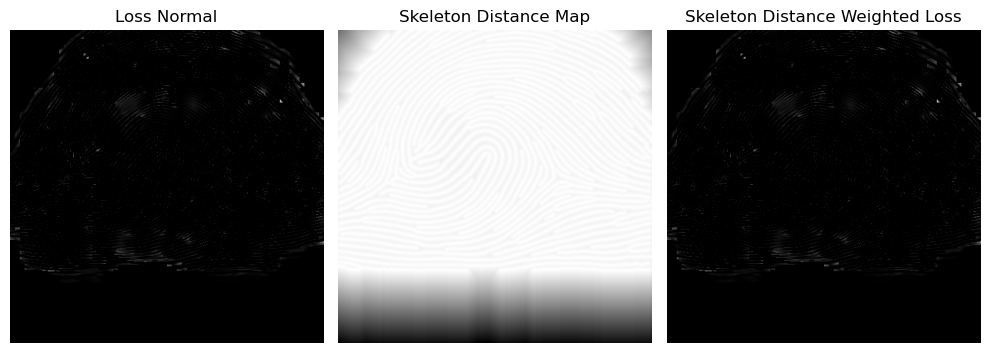

In [ ]:
class MyWeightedL1Loss(nn.L1Loss):
    def __init__(self, reduction='none'):
        super(MyWeightedL1Loss, self).__init__(reduction=reduction)

    def forward(self, input, target, pixel_weight):
        pixel_mae = super(MyWeightedL1Loss, self).forward(input, target)
        loss = pixel_mae * pixel_weight
        print(loss.shape)
        return loss.sum()/(loss.size(0)) # mean per-image loss (not per-pixel or per-batch).


loss_map           = torch.nn.functional.binary_cross_entropy_with_logits(enh[:,1,:,:], bin, reduction = 'none')
# minutia_weight_map =  extract_mcc_cpu(mnts_label, img.shape, 12, 5.0)
# minutia_weight_map.shape
# minutia_weight_map = (minutia_weight_map - torch.min(minutia_weight_map)) / (torch.max(minutia_weight_map) - torch.min(minutia_weight_map))

criterion = MyWeightedL1Loss()

simple_loss   = torch.mean(loss_map)
weighted_loss = torch.mean(loss_map * skel)

# old_loss = criterion(enh[:,1,:,:], skel, skel)

# mean_mask_loss = torch.mean(torch.sum(loss_map * skel, dim=(1,2)) / (torch.sum(skel, dim=(1,2)) + 1e-7) )


print("Simple loss: ", simple_loss)
print("Weighted loss: ", weighted_loss)

fig, ax = plt.subplots(figsize = (10,4), nrows = 1, ncols = 3)
ax[0].imshow((loss_map)[0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title("Loss Normal")
ax[1].imshow(skel[0], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title("Skeleton Distance Map")
ax[2].imshow((loss_map * skel)[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title("Skeleton Distance Weighted Loss")


fig.tight_layout()
plt.show()

In [ ]:
mean_mask_loss.shape

NameError: name 'mean_mask_loss' is not defined

In [ ]:
loss_map.shape

torch.Size([2, 512, 512])

In [ ]:
enh.shape

torch.Size([2, 1, 512, 512])

In [ ]:
mnt_map.shape

torch.Size([2, 512, 512])